#  Week 8-  Quantum simulations <a class="tocSkip">
    (c) Ariel Guerreiro 2023

Welcome to this Jupyter notebook on quantum simulation! This notebook will explore the exciting applications of quantum information to quantum simulation. Although this is a broad topic, the focus of this notebook is to present the core model in physics and develop several simulations with increasing degrees of complexity.

The aim is to keep the content simple, so there is no need for complicated mathematical derivations to follow the construction of the simulations. Instead, we will explore the models with some detail and investigate various case studies to help build an intuitive understanding of the concepts.

The notebook will start by presenting the quantum model of the harmonic oscillator and a computational model of it. We will adjust the quantum model, map the states of the system into the states of the simulator, develop the simulation Hamiltonian, and implement the simulation.

Following that, we will investigate the particle in a potential well model, where we will adjust the quantum model, map the states of the system into the states of the simulator, develop the simulation Hamiltonian, and implement the simulation. Then, we will extend the model by combining two wells and adding an environment.

Finally, we will explore some case studies, such as the tunneling effect, Rabi oscillations, the Kronig-Penney model, and adding an environment to the system.

By the end of this notebook, you will have gained a better understanding of quantum simulation and how to implement it in various models. Let's dive in!


# Before we start... <a class="tocSkip">
 
  Let us begin by runnning the initialization cell
    
$$
\def\ket#1{\left|#1\right\rangle }%
\def\bra#1{\left\langle #1\right|}%
\def\braket#1#2{\langle#1|#2\rangle}%
$$
   

In [1]:
import numpy as np
import math as mt
import scipy as sp
import matplotlib.pyplot as plt
import random
import re             # regular expressions module
import sys



from tqdm.notebook import tqdm
from scipy.linalg import block_diag


from pylab import plot
from qiskit import *
from qiskit.visualization import *
from qiskit.ignis.verification import *

# importing specific packages of Qiskit
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute



from IPython.display import display, Image, SVG, Math, YouTubeVideo

%matplotlib inline

So the idea is to explore the many flavors of oscillators using a quantum computer. Of course, we need to clarify whether we are considering the classical or the quantum model for oscillators.

Indeed, we can have quantum simulations of classical models and quantum simulations of quantum models. In both cases, they are quantum simulations, but the second situation is "twice quantum" and therefore more interesting. We shall begin precisely with that case.

# The quantum model of the harmonic oscillator in a nutshell

The classical model for a harmonic oscillator can be derived using Hamilton's variational formalism in terms of two canonical variables: the generalized position $x$ and the generalized momentum $p$. In this formalism, the particle dynamics in one dimension is described by a Hamiltonian given by:

$$
H = \frac{p^2}{2m} + V(x)
$$

The potential corresponds to the function:

$$
V(x) = \frac{1}{2}m\omega^2 x^2
$$

The quantum model for the harmonic oscillator is obtained by replacing the classical variables $x$ and $p$ with two self-adjoint operators, $\hat{x}$ and $\hat{p}$, respectively, satisfying the canonical commutation relation:

$$
[\hat{x}, \hat{p}] = i\hbar
$$

Thus, the classical Hamiltonian becomes the quantum Hamiltonian operator:

$$
\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2}m\omega^2 \hat{x}^2
$$

A possible representation for the quantum operators is the **position representation**, which is given by:

$$
\hat{p} = -i\hbar \frac{\partial}{\partial x}, \quad \hat{x} = x
$$

Here, the state of the system is described by the wavefunction $\psi(x) = \langle x | \psi \rangle$, where $|x\rangle$ is the position eigenvector.

The evolution of the system is governed by the time-dependent Schrödinger equation:

$$
i\hbar \frac{\partial}{\partial t} \psi(x, t) = \hat{H} \psi(x, t)
$$

The stationary solutions of this equation are of the form:

$$
\psi_n(x) = \frac{1}{\sqrt{2^n n!}} \left( \frac{m\omega}{\pi\hbar} \right)^{1/4} e^{-\frac{m\omega x^2}{2\hbar}} H_n\left( \sqrt{\frac{m\omega}{\hbar}} x \right)
$$

where $H_n$ are the Hermite polynomials. The corresponding energy levels are:

$$
E_n = \hbar\omega \left(n + \frac{1}{2}\right)
$$

The dynamics of the harmonic oscillator can also be described using the **raising** and **lowering** operators:

$$
\hat{a}^\dagger = \sqrt{\frac{m\omega}{2\hbar}} \left( \hat{x} - \frac{i}{m\omega} \hat{p} \right), \quad
\hat{a} = \sqrt{\frac{m\omega}{2\hbar}} \left( \hat{x} + \frac{i}{m\omega} \hat{p} \right)
$$

Using these, the Hamiltonian operator can be written as:

$$
\hat{H} = \hbar\omega \left( \hat{a}^\dagger \hat{a} + \frac{1}{2} \right)
$$

The **ground state** of the oscillator is defined by:

$$
\hat{a} |0\rangle = 0
$$

Another important class of states are the **Fock states** $|n\rangle$, which are eigenstates of the number operator $\hat{N} = \hat{a}^\dagger \hat{a}$ with eigenvalue $n$. Since:

$$
\hat{H} = \hbar\omega \left( \hat{N} + \frac{1}{2} \right)
$$

Fock states are also eigenstates of the Hamiltonian, i.e., stationary solutions of the Schrödinger equation.

The ladder operators act on Fock states as:

$$
\hat{a}^\dagger |n\rangle = \sqrt{n+1} |n+1\rangle, \quad 
\hat{a} |n\rangle = \sqrt{n} |n-1\rangle, \quad
\hat{a}^\dagger \hat{a} |n\rangle = n |n\rangle
$$

Thus, higher occupation states are obtained from the ground state by applying the raising operator successively.

Fock states are **orthonormal**:

$$
\langle m | n \rangle = \delta_{mn}
$$

and **complete**:

$$
\sum_{n=0}^\infty |n\rangle \langle n| = \mathbf{1}
$$

where $\mathbf{1}$ is the identity operator. Since Fock states have finite norm, they form a complete basis for the Hilbert space.

The **matrix forms** of the creation and annihilation operators in the Fock basis are:

$$
\hat{a}^\dagger = 
\begin{pmatrix}
0 & 0 & 0 & \dots \\
\sqrt{1} & 0 & 0 & \dots \\
0 & \sqrt{2} & 0 & \dots \\
0 & 0 & \sqrt{3} & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}
$$

$$
\hat{a} = 
\begin{pmatrix}
0 & \sqrt{1} & 0 & 0 & \dots \\
0 & 0 & \sqrt{2} & 0 & \dots \\
0 & 0 & 0 & \sqrt{3} & \dots \\
0 & 0 & 0 & 0 & \ddots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
$$

And with this brief discussion, we have reviewed the main aspects of the quantum model of the harmonic oscillator.

We are now ready to develop a (quantum) computational model of the oscillator.


# A computational model of the quantum harmonic oscillator
The essence of a quantum simulation is to find an unitary transformation $\Phi$ that 
* maps the state of the original quantum system, say $\psi(t)$, into the state of the quantum register of the quantum computer (the quantum simulator), say $\phi(t)$, such that
$$
\phi(t) = \Phi \psi(t); 
$$
* produces an  Hamiltonian describing the physical system, say $H_{sys}$ in terms of the states of the quantum computer, say $H_{sim}$ such that
$$
H_{sim}= \Phi H_{sys} \Phi^{-1}.
$$


## Adjusting the quantum model
So let us begin by attempting to map the states of the harmonic oscillator into the states of the register. A naif approach is to consider the basis of stationary states of the Harmonic oscillator and map them into the computational basis of the quantum register.

The first difficulty is that the Hilbert space of the harmonic oscillator has infinite dimensions. Indeed, there is an infinite number of mutually orthogonal Fock states, while the number of registers available in a real quantum computer is finite and thus, so is finite the number of elements of the computational basis.

A solution is to truncate the range of accessible states of the harmonic oscillator to a handful, for example
$$
\vert 0 \rangle, \vert 1 \rangle, \vert 2 \rangle, \text{ and } \vert 3 \rangle
$$
Of curse, this is only valid if in someway we can guarantee that the state of the oscillator never reaches higher energy states, which could be achieved by constrains on the energy available to the oscillator. This implies that the raising and lowering operators also can be represented by finite matrices:

$$
\begin{align*}
a^{\dagger }={\begin{pmatrix}
0&0&0&0\\
{\sqrt {1}}&0&0&0\\
0&{\sqrt {2}}&0&0\\
0&0&{\sqrt {3}}&0\end{pmatrix}}
\quad\quad\quad\quad
a={\begin{pmatrix}
0&{\sqrt {1}}&0&0\\
0&0&{\sqrt {2}}&0\\
0&0&0&{\sqrt {3}}\\
0&0&0&0
\end{pmatrix}}
\end{align*}
$$

Resulting in the Hamiltonian operator:
\begin{equation}
H=\hbar \omega{\begin{pmatrix}
0&0&0&0\\
0&1&0&0\\
0&0&2&0\\
0&0&0&3
\end{pmatrix}}+\frac{1}{2}
\end{equation}

Basically, we have developed a model of the quantum system that can be casted into a quantum computer.

## Mapping the states of the system into the states of the simulator

The next step is to map the original system into the quantum computer (the simulator). In particular, we want to find a transformation $\Phi$ that describes an one-to-one correspondence between the elements of the basis of the Hilbert space associated with the original physical system and those associated with the computer register.

In this case there is an intuitive mapping by associating each excitation level of the oscillator and the elements of the computational basis of a two qubit register
$$
\vert {0}_{sys} \rangle \rightarrow \vert {00}_{sim} \rangle \\
\vert {1}_{sys} \rangle \rightarrow \vert {01}_{sim} \rangle \\
\vert {2}_{sys} \rangle \rightarrow \vert {10}_{sim} \rangle \\
\vert {3}_{sys} \rangle \rightarrow \vert {11}_{sim} \rangle,
$$
which can be described by the following transformation
$$
\Phi = 
\vert {00}_{sim} \rangle \langle {0}_{sys} \vert +
\vert {01}_{sim} \rangle \langle {1}_{sys} \vert +
\vert {10}_{sim} \rangle \langle {2}_{sys} \vert +
\vert {11}_{sim} \rangle \langle {3}_{sys} \vert.
$$
This is obviously a unitary transformation, whose inverse is trivial to calculate

$$
\Phi^{-1} = \Phi^{\dagger} =
\vert  {0}_{sys}\rangle \langle {00}_{sim} \vert +
\vert  {1}_{sys}\rangle \langle {01}_{sim} \vert +
\vert  {2}_{sys}\rangle \langle {10}_{sim} \vert +
\vert  {3}_{sys}\rangle \langle {11}_{sim} \vert.
$$


## Developing the simulation Hamiltonian
The next step is to find the simulation Hamiltonian obtained from the mapping produced by $\Phi$
$$
H_{sim}= \Phi H_{sys} \Phi^{-1} = \hbar \omega{\begin{pmatrix}
0&0&0&0\\
0&1&0&0\\
0&0&2&0\\
0&0&0&3
\end{pmatrix}}+\frac{1}{2}
$$
This is very similar to the Hamiltonian of the original system, but if analyze it carefully there a subtle difference, which is clearer in when representing the two operators in the projector form, say
$$
H_{sys} = \hbar \omega \left(
\frac{1}{2} \langle {0}_{sys}\vert {0}_{sys}\rangle +
\frac{3}{2} \langle {1}_{sys}\vert {1}_{sys}\rangle +
\frac{5}{2} \langle {2}_{sys}\vert {2}_{sys}\rangle +
\frac{7}{2} \langle {3}_{sys}\vert {3}_{sys}\rangle
\right)
$$
and
$$
H_{sim} = \hbar \omega \left(
\frac{1}{2} \langle {00}_{sim}\vert {00}_{sim}\rangle +
\frac{3}{2} \langle {01}_{sim}\vert {01}_{sim}\rangle +
\frac{5}{2} \langle {10}_{sim}\vert {10}_{sim}\rangle +
\frac{7}{2} \langle {11}_{sim}\vert {11}_{sim}\rangle
\right).
$$
While the first operator acts on the states of the original quantum system, the second describes an evolution of the states of the quantum register in the quantum computer.

I told you that it was subtle!

## Implementing the simulation

So far this example has been quite straightforward. Apart from some quantum mechanics, all the mathematical derivations were all but trivial. Yet, it has allowed us to go through all the steps in developing the computational model associated with the quantum simulation of a quantum system.

We continue with this approach and target the simplest simulation possible with our truncated model of the harmonic oscillator: the study of the evolution of the state of the system. So our goal is to solve the Schrödinger equation
$$
i \partial_t \vert \phi \rangle = H_{sim} \vert \phi \rangle
$$
for a particular initial condition, say for example
$$
\vert {\psi}_{sim}\rangle = \frac{1}{\sqrt{2}} \left({00}_{sim}\rangle + {01}_{sim}\rangle \right).
$$
The latter corresponds to a cat state describing the even superposition of the ground and the first excited states of the oscillator. Naturally, over time we expect the relative phase between the two components of the superposition to vary, as the Bloch vector (the other degrees of freedom never come into play hence, we are left with two degrees of freedom that can be mapped to a Bloch sphere) rotates around the Z-axis.

Since this is an introductory level course, we shall not be concerned with the problem of decomposing the Hamiltonian and the evolution operator in terms of gates. Instead, we shall use an operation available in Qiskit,

QuantumCircuit.hamiltonian,

which does all that work for us. Thanks Qiskit!

In [2]:
# Initializing a two-qubit quantum state
initial_state = [
    1/mt.sqrt(2)+0.j,
    1/mt.sqrt(2)+0.j,
    0,
    0]
#Constructing the Hamiltonian
H = [
    [0.5,0,0,0],
    [0,1.5,0,0],
    [0,0,2.5,0],
    [0,0,0,3.5]
]
#final time
time = 0.5
# Create a Quantum Circuit acting on a quantum register of 1 qubits and 2 bits
q = QuantumRegister(2, name = 'q')
circuit0 = QuantumCircuit(q,name='qc')
# Create the superposition state to show that things are working
circuit0.initialize(initial_state, [q[0],q[1]])
# In this code we are going to use an procedure already defined in Qiskit 0.20, 
# which computes the evolution of the state of the register (qubits q[0] and q[1])
circuit0.hamiltonian(H, time,[q[0],q[1]])
simulator = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(circuit0, simulator).result()
final_state = result.get_statevector(circuit0, decimals=16)

print('Initial state:\t', initial_state[0],' |00>',initial_state[1],' |01>',initial_state[2],' |10>',initial_state[3],' |11>')
print('Final state:\t', final_state[0],' |00>',final_state[1],' |01>',final_state[2],' |10>',final_state[3],' |11>')

Initial state:	 (0.7071067811865475+0j)  |00> (0.7071067811865475+0j)  |01> 0  |10> 0  |11>
Final state:	 (0.6851245437674767-0.17494101728127343j)  |00> (0.5173821608993933-0.4819913895320894j)  |01> 0j  |10> 0j  |11>


## Exercises <a class="tocSkip">

1. Represent the Bloch vector of the state 
$$
\vert {\psi}_{sim}\rangle = \frac{1}{\sqrt{2}} \left({00}_{sim}\rangle + {01}_{sim}\rangle \right).
$$
in the Bloch sphere and show that it rotates around the z-axis.
    
## Exercises for extra credits <a class="tocSkip">
    
2. Test this quantum circuit in the IBM computer.
    
 What are the differences found? Can you explain them?

    

    
# Particle in a potential well


$$
H=\frac{p^{2}}{2m}+V(x).
$$
The potential corresponds to the function
$$
V(x) ={\begin{cases}
0,&{\mbox{if }}x<-L/2 {\mbox{ (the region I outside the well)}}\\
-V_0,&{\mbox{if }}-L/2<x<L/2 {\mbox{ (the region II inside the well)}}\\
0,&{\mbox{if }}x>L/2{\mbox{  (the region III outside the well)}}
\end{cases}}
$$ 


$$
\Psi(x) ={\begin{cases}
\psi _{1}(x),&{\mbox{if }}x<-L/2{\mbox{ (the region I outside the well)}}\\
\psi _{2}(x),&{\mbox{if }}-L/2<x<L/2{\mbox{ (the region II inside the well)}}\\
\psi _{3}(x),&{\mbox{if }}x>L/2{\mbox{  (the region III outside the well)}}
\end{cases}}
$$

For bounded states the energy is negative and we find
$$
\psi_{1}(x)=Ge^{{\alpha x}}\\
\psi_{2}(x)=A\sin(kx)+B\cos(kx)\\
\psi_{3}(x)=He^{{-\alpha x}}\\
$$
The boundary conditions result into two sorts of solutions, symmetric, for which $A=0$ and $G=H$, and antisymmetric, for which $B=0$ and $G=-H$. The symmetric and antisymmetric solutions must satisfy respectively
$$
\alpha =k\tan(kL/2)\\
\alpha =-k\cot(kL/2).
$$
The continuity conditions cannot be satisfied for an arbitrary value of the energy thus, only certain energy values, which are solutions on of these two equations, are allowed. 

The previous equations cannot be solved analytically and, depending on the width $L$ and depth $V_0$ of the potential, this system may have different and finite number of solutions. 

By contrast, positive energy levels have a continuous spectrum.

from these result we can write the total Hamiltonian of the system as
$$
\widehat{H}=\widehat{H}_{bounded} + \widehat{H}_{unbounded},
$$
where the first term describes the contribution from bounded states
$$
\widehat{H}_{bounded} = \sum_{n=0}^{N-1} E_{n} \vert \Psi_{n} \rangle \langle \Psi_{n} \vert
$$
and the second from the unbounded modes
$$
\widehat{H}_{unbounded} \approx \int_{-\infty}^{+\infty} \hbar \omega(k) \vert k \rangle \langle k \vert
$$
Note that $\langle k \vert$  describe plane-wave modes the propagate throughout the system with a dispersion relation $\omega(k)$, which already take into account the effects of the presence of the potential well.

## Adjusting the quantum model

The main challenge of this model is that it includes the continuous spectrum of eigenstates for the unbounded modes. This is something that it is extremely demanding in terms o memory and something not easy to model in a quantum digital computer. But let us turn to Physics for an insight.

First, we usually interested in the bounded states, especially the transitions between bounded states. Second, and from this point of view, the unbounded modes work as a bath or environment that introduces fluctuations in the model. If we are not interested in characterizing the system in terms of the quantum states of the unbounded modes or if they cannot be characterized in full in a real experiment then, we may introduce the effects of the unbounded system as quantum noise.

Therefore, we have that
$$
\widehat{H} \approx \widehat{H}_{bounded} .
$$

## Mapping the states of the system into the states of the simulator

Once we have limited the states of interest to the bounded states, we can reuse the model initially developed for the harmonic oscillator, and make
$$
\vert \Psi_{0} \rangle \rightarrow \vert {00}_{sim} \rangle \\
\vert \Psi_{1} \rangle \rightarrow \vert {01}_{sim} \rangle \\
\vert \Psi_{2} \rangle \rightarrow \vert {10}_{sim} \rangle \\
\vert \Psi_{3} \rangle \rightarrow \vert {11}_{sim} \rangle
$$
resulting in the transformations
$$
\Phi =
\vert {00}_{sim} \rangle \langle \Psi_{0} \vert +
\vert {01}_{sim} \rangle \langle \Psi_{1} \vert +
\vert {10}_{sim} \rangle \langle \Psi_{2} \vert +
\vert {11}_{sim} \rangle \langle \Psi_{3} \vert
$$
and
$$
\Phi^{-1} = \Phi^{\dagger} =
\vert \Psi_{0}\rangle \langle {00}_{sim} \vert +
\vert \Psi_{1}\rangle \langle {01}_{sim} \vert +
\vert \Psi_{2}\rangle \langle {10}_{sim} \vert +
\vert \Psi_{3}\rangle \langle {11}_{sim} \vert.
$$

The main difference between this model and the harmonic oscillator is in the approximations used to get a physical model that can be mapped to the quantum computer:
* Harmonic oscillator: the states are discrete but infinite, so we have truncated the number of levels accessible to the system;
* Particle in a well: the bounded states are discrete and finite but the unbounded states have a continuous spectrum, so we remove the unbounded modes and look at them as a noise source.


## Developing the simulation Hamiltonian
So finally we arrive at a simulation operator of the form
$$
H_{sim} =
E_{0} \langle {00}_{sim}\vert {00}_{sim}\rangle +
E_{1} \langle {01}_{sim}\vert {01}_{sim}\rangle +
E_{2} \langle {10}_{sim}\vert {10}_{sim}\rangle +
E_{3} \langle {11}_{sim}\vert {11}_{sim}\rangle
$$
where the values of the energy levels $E_n$ are obtained as solutions of equations (37).

## Implementing the simulation

We continue with this approach and target the simplest simulation possible with our truncated model of the harmonic oscillator: the study of the evolution of the state of the system. So our goal is to solve the Schrödinger equation
$$
i \partial_t \vert \phi \rangle = H_{sim} \vert \phi \rangle
$$
for a particular initial condition, say for example
$$
\vert {\psi}_{sim}\rangle = \vert{00}_{sim}\rangle .
$$

Obviously the code is the same as before, but just for completeness, here it is:

In [ ]:
# Initializing a two-qubit quantum state
initial_state = [
    1,
    0,
    0,
    0]
#Constructing the Hamiltonian
H = [
    [0.5,0,0,0],
    [0,1.5,0,0],
    [0,0,2.5,0],
    [0,0,0,3.5]
]
#final time
time = 0.5
# Create a Quantum Circuit acting on a quantum register of 1 qubits and 2 bits
q = QuantumRegister(2, name = 'q')
circuit0 = QuantumCircuit(q,name='qc')
# Create the superposition state to show that things are working
circuit0.initialize(initial_state, [q[0],q[1]])
# In this code we are going to use an procedure already defined in Qiskit 0.20, 
# which computes the evolution of the state of the register (qubits q[0] and q[1])
circuit0.hamiltonian(H, time,[q[0],q[1]])
simulator = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(circuit0, simulator).result()
final_state = result.get_statevector(circuit0, decimals=16)

print('Initial state:\t', initial_state[0],' |00>',initial_state[1],' |01>',initial_state[2],' |10>',initial_state[3],' |11>')
print('Final state:\t', final_state[0],' |00>',final_state[1],' |01>',final_state[2],' |10>',final_state[3],' |11>')

## Extending the model

### Combining two wells

So far the model of a particle in a well is not that interesting, since it resembles the model used for the harmonic oscillator but where the energy levels are not evenly separated. That makes the phase variation of each component of the wave function in terms of eigenstate not commensurable, so the system is not really periodic.

To make things more interesting, we are going to add a few more spices into the pan and extend the model just a bit more. This will help you in understanding how to augment your models of simple things into more interesting situations.

So we are going to look at a particle in a two-well potential, satisfying the Hamiltonian
$$
H=\frac{p^{2}}{2m}+V(x).
$$
with
$$
V(x) =U(x - d/2) + U(x + d/2)
$$
and
$$
U(x) ={\begin{cases}
0,&{\mbox{if }}x<-L/2 {\mbox{ (the region I outside the well)}}\\
-V_0,&{\mbox{if }}-L/2<x<L/2 {\mbox{ (the region II inside the well)}}\\
0,&{\mbox{if }}x>L/2{\mbox{ (the region III outside the well)}}
\end{cases}}
$$
where $d$ is the separation between the wells (center to center).

The idea is now to use a Sommerfeld type of solution, where we assume that the solutions of the single well are good approximations of stationary solutions of the system. In other words, the presence of the second wells produces little correction to the initial solutions and if each well has $N$ bounded solutions, then the system with two wells has $2 \times N$ solutions:
* $N$ localized in the first well; and
* $N$ localized in the second well.

So the basis of the Hilbert space looks something like this
$$
\{\vert 000\rangle, \vert 001\rangle, \vert 010\rangle, \vert 011\rangle, \vert 100\rangle \ldots \vert 111\rangle\}
$$
where the first qubit (on leftmost ) refers to the well were the solution is localized. For example, the state
$$
\vert 100\rangle
$$
indicates a state in the oscillator "1" (for example, the rightmost) in the ground state "00".

Obviously, the elements of this basis are not completely orthogonal, since their overlaps between modes in different wells are not exactly zero, but if $d>>L$ these overlaps are almost zero. If you wanna be certain that they are orthogonal, you can always do a Smith orthogonalization. For now, we assume that orthogonal enough.
In this case, we can write the unit operator as
$$
\mathbf{1} \approx \sum_{n=0}^1 \sum_{m=0}^1 \sum_{l=0}^1 \vert nml\rangle \langle nml\vert
$$
and use it to get the decomposition of the Hamiltonian in this basis
$$
H = \mathbf{1} H \mathbf{1} = H_{1^{st}well} + H_{2^{nd}well} + H_{corr}
$$
where $H_{1^{st}well}$ and $H_{2^{nd}well}$ are respectively the Hamiltonians of the first and second wells taken independently and $H_{corr}$ are the correction introduced by the coupling between the wells
$$
H_{corr} = \sum_{n=0}^1 \sum_{m=0}^1 \sum_{l=0}^1, \sum_{n'=0}^1 \sum_{m'=0}^1 \sum_{l'=0}^1 \vert nml\rangle \langle nml\vert H \vert n'm'l'\rangle \langle n'm'l'\vert - H_{1^{st}well} - H_{2^{nd}well}
$$
which, under the approximations used so far, should be a weak correction.

In the matrix form, the Hamiltonian operator is diagonally dominant, which is always a good thing when numerical solutions are concerned, but also because it tells us that we are under the conditions of the perturbative theory. Even though we are not going to compute perturbative solutions, this allows us to compare the simulation results with analytical solutions obtained from perturbative methods. Allegedly, the quantum computer performs an "exact" simulations, though the notion of "exact" can be debatable in terms of how the computer actually conducts the calculations, something beyond the scope of this course.

For simplicity, we shall choose generic values for the overlaps, rather than doing calculations for an actual case.


In the case where there is no interaction between states in the same well and the coupling between states of different wells are identical the quantum circuit can look something like this.

In [3]:
# Initializing a two-qubit quantum state
initial_state = [
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0
]
#Constructing the Hamiltonian
g0= 0.1
H = [
    [0.5,0,0,0,g0,g0,g0,g0],
    [0,1.5,0,0,g0,g0,g0,g0],
    [0,0,2.5,0,g0,g0,g0,g0],
    [0,0,0,3.5,g0,g0,g0,g0],
    [g0,g0,g0,g0,0.5,0,0,0],
    [g0,g0,g0,g0,0,1.5,0,0],
    [g0,g0,g0,g0,0,0,2.5,0],
    [g0,g0,g0,g0,0,0,0,3.5]
    
]
#final time
time = 0.5
# Create a Quantum Circuit acting on a quantum register of 1 qubits and 2 bits
q = QuantumRegister(3, name = 'q')
circuit0 = QuantumCircuit(q,name='qc')
# Create the superposition state to show that things are working
circuit0.initialize(initial_state, [q[0],q[1],q[2]])

circuit0.hamiltonian(H, time,[q[0],q[1],q[2]])
simulator = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(circuit0, simulator).result()
final_state = result.get_statevector(circuit0, decimals=5)

print('Initial state:\t', initial_state)
print('Final state:\t', final_state)

Initial state:	 [1, 0, 0, 0, 0, 0, 0, 0]
Final state:	 [ 0.96470055-0.24513797j -0.00378152+0.00295263j -0.00319564+0.00350854j
 -0.00250081+0.00389478j -0.01218525-0.04818699j -0.02350522-0.04318921j
 -0.03243571-0.03487507j -0.03797496-0.02438344j]


An now with a cat state.

In [4]:
# Initializing a two-qubit quantum state
initial_state = [
    1/mt.sqrt(2)+0.j,
    1/mt.sqrt(2)+0.j,
    0,
    0,
    0,
    0,
    0,
    0
]
#Constructing the Hamiltonian
g0= 0.1
H = [
    [0.5,0,0,0,g0,g0,g0,g0],
    [0,1.5,0,0,g0,g0,g0,g0],
    [0,0,2.5,0,g0,g0,g0,g0],
    [0,0,0,3.5,g0,g0,g0,g0],
    [g0,g0,g0,g0,0.5,0,0,0],
    [g0,g0,g0,g0,0,1.5,0,0],
    [g0,g0,g0,g0,0,0,2.5,0],
    [g0,g0,g0,g0,0,0,0,3.5]
    
]
#final time
t_max = 100
dt = 1.0
n_qubits = 3 

time = np.arange(dt,t_max,dt)

shots =2048
# Create a Quantum Circuit acting on a quantum register
data = []
for t in time:

    q = QuantumRegister(3, name = 'q')
    c = ClassicalRegister(3, name = 'c')
    circuit1 = QuantumCircuit(q,c,name='qc')
    # Create the superposition state to show that things are working
    circuit1.initialize(initial_state, [q[0],q[1],q[2]])

    circuit1.hamiltonian(H, t,[q[0],q[1],q[2]])

    circuit1.measure(0,0)
    circuit1.measure(1,1)
    circuit1.measure(2,2)
    simulator = Aer.get_backend('qasm_simulator')
    results = execute(circuit1, backend = simulator, shots=shots).result()
    counts = results.get_counts()
    data.append([t,counts])
   

To make the results easier to understand, we include some data manipulation tools.

In [5]:
def binary_list(n):
    return ['{:0{}b}'.format(i, n) for i in range(2**n)]

# Python program to get dictionary keys as list 
def getList(dict):   
    return [*dict] 

def getStruturedData_grid(data, n_qubits):
    X = []
    Y = []
    Z = [] 
    
    if 1==1:
        states_list = binary_list(n_qubits)
        for a in data:
            time, dictOfElements = a
            listOfItems = dictOfElements.items()
            rowX = []
            rowY = []
            rowZ = []
            for state in states_list:
                if state in dictOfElements.keys():
                    rowX.append(time)
                    rowY.append(int(state,2))
                    rowZ.append(dictOfElements[state])
                else:
                    rowX.append(time)
                    rowY.append(int(state,2))
                    rowZ.append(0)
            X.append(rowX)
            Y.append(rowY)
            Z.append(rowZ)
            
        return np.array(X,dtype=float), np.array(Y,dtype=float), np.array(Z,dtype=float)

def getStruturedData_seq(data, n_qubits = 0):
    X = []
    Y = []
    Z = [] 
    
    if n_qubits == 0:
        for a in data:
            time, dictOfElements = a
            listOfItems = dictOfElements.items()
            for item in listOfItems:
                X.append(time)
                Y.append(int(item[0],2))
                Z.append(item[1])
        return np.array(X,dtype=float), np.array(Y,dtype=float), np.array(Z,dtype=float)
    else:
        states_list = binary_list(n_qubits)
        for a in data:
            time, dictOfElements = a
            listOfItems = dictOfElements.items()
            for state in states_list:
                if state in dictOfElements.keys():
                    X.append(time)
                    Y.append(int(state,2))
                    Z.append(dictOfElements[state])
                else:
                    X.append(time)
                    Y.append(int(state,2))
                    Z.append(0)
        return np.array(X,dtype=float), np.array(Y,dtype=float), np.array(Z,dtype=float)

This helps us to better visualize the results.

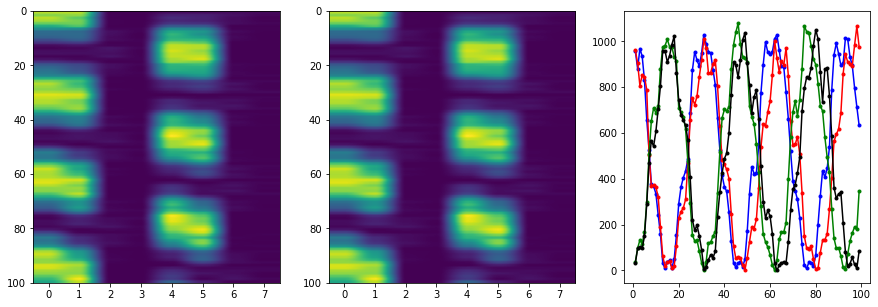

In [6]:
X,Y,Z = getStruturedData_grid(data,3)
x,y,z = getStruturedData_seq(data,n_qubits = 3)


f, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, 8-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, 8-0.5, t_max, 0), interpolation = 'hanning')
index = np.where(y==0)
ax[2].plot(x[index],z[index], '-b.')
index = np.where(y==1) 
ax[2].plot(x[index],z[index], '-r.')
index = np.where(y==4)
ax[2].plot(x[index],z[index], '-g.')
index = np.where(y==5) 
ax[2].plot(x[index],z[index], '-k.')

plt.savefig('test.png')

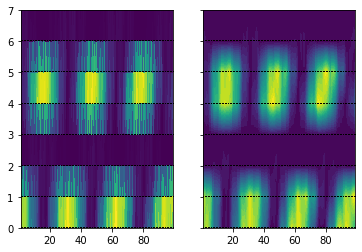

In [7]:
x,y,z = getStruturedData_seq(data,3)

f, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].tripcolor(x,y,z)
ax[1].tricontourf(x,y,z, 30) 
ax[1].plot(x,y, 'k,')
ax[0].plot(x,y, 'k,')
plt.savefig('test.png')

How to interpret these results? Basically, the cat state is tunneling back and forth between the two wells. Yeap, Physics is beautiful!

### Adding an environment

What else can we add to the model?

Remember the unbounded state that we have taken out of the model? Lets put it back in the form of noise.

We begin by developing a thermal noise generator, using the same code discussed in a previous lecture.

In [8]:
from qiskit.providers.aer import QasmSimulator

# Qiskit Aer noise module imports
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

def generate_noise_model(n_qubits, T1 = 50e3, dT1 = 10e3):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(T1, dT1, n_qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(T1, dT1, n_qubits)  # Sampled from normal distribution mean 50 microsec

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(n_qubits)])

    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                      for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                  for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                 thermal_relaxation_error(t1b, t2b, time_cx))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(n_qubits):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(n_qubits):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    return noise_thermal

The noise model for this case could be:

In [9]:
n_qubits = 3
noise_thermal = generate_noise_model(n_qubits, T1 = 1.0e3, dT1 = 0.1e3)
print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'reset', 'measure', 'u3', 'cx']
  Qubits with noise: [0, 1, 2]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2])]


So, when we rerun the simulations we introduce some fluctuations.

In [10]:
# Initializing a two-qubit quantum state
initial_state = [
    1/mt.sqrt(2)+0.j,
    1/mt.sqrt(2)+0.j,
    0,
    0,
    0,
    0,
    0,
    0
]
#Constructing the Hamiltonian
g0= 0.1
H = [
    [0.5,0,0,0,g0,g0,g0,g0],
    [0,1.5,0,0,g0,g0,g0,g0],
    [0,0,2.5,0,g0,g0,g0,g0],
    [0,0,0,3.5,g0,g0,g0,g0],
    [g0,g0,g0,g0,0.5,0,0,0],
    [g0,g0,g0,g0,0,1.5,0,0],
    [g0,g0,g0,g0,0,0,2.5,0],
    [g0,g0,g0,g0,0,0,0,3.5]
    
]

t_max = 100
dt = 1.0

time = np.arange(dt,t_max,dt)

shots =2048
# Create a Quantum Circuit acting on a quantum register
data = []
for t in time:
    #print(t)
    q = QuantumRegister(3, name = 'q')
    c = ClassicalRegister(3, name = 'c')
    circuit1 = QuantumCircuit(q,c,name='qc')
    # Create the superposition state to show that things are working
    circuit1.initialize(initial_state, [q[0],q[1],q[2]])

    circuit1.hamiltonian(H, t,[q[0],q[1],q[2]])

    circuit1.measure(0,0)
    circuit1.measure(1,1)
    circuit1.measure(2,2)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit1, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
    results = job.result()
    counts = results.get_counts()

    data.append([t,counts])

After visualization, we get

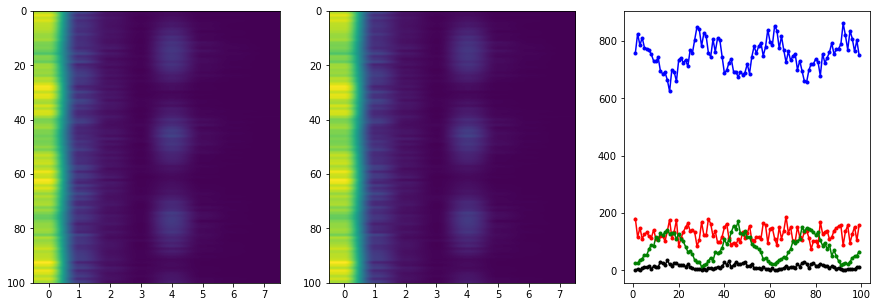

In [11]:
X,Y,Z = getStruturedData_grid(data,3)
x,y,z = getStruturedData_seq(data,n_qubits = 3)


f, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, 8-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, 8-0.5, t_max, 0), interpolation = 'hanning')
index = np.where(y==0)
ax[2].plot(x[index],z[index], '-b.')
index = np.where(y==1) 
ax[2].plot(x[index],z[index], '-r.')
index = np.where(y==4)
ax[2].plot(x[index],z[index], '-g.')
index = np.where(y==5) 
ax[2].plot(x[index],z[index], '-k.')

plt.savefig('test.png')

Interestingly, introducing noise cancels the tunneling. How to explain this? Why should noise prevent a particle or a state from tunneling between the two wells? 

Any clues? I told you: Physics is beautiful!

## Some case studies

The interesting thing about quantum simulations it that we can explore quantum mechanics in way that is totally equivalent to performing the experiments (at least if you use the quantum computer).

We shall look into more detail to two specific situations: 
* The tunneling effect; and
* Rabi oscillations


### Tunneling effect

In the previous example, we have shown that is is possible to tunnel a strongly coherent state between two wells. But our previous model had more effects intertwined. Lot let us choose a model where the only effect is tunneling.


Before we start, let us introduce some tools to automize the construction of the quantum circuit.

In [12]:
def tridiag(c, u, d, N): 
    # c, u, d are center, upper and lower blocks, repeat N times
    cc = block_diag(*([c]*N)) 
    shift = c.shape[1]
    uu = block_diag(*([u]*N)) 
    uu = np.hstack((np.zeros((uu.shape[0], shift)), uu[:,:-shift]))
    dd = block_diag(*([d]*N)) 
    dd = np.hstack((dd[:,shift:],np.zeros((uu.shape[0], shift))))
    return cc+uu+dd

def getNumberQubits(n_levels,n_wells):

    n_qubits = int(np.ceil(mt.log2(n_wells*n_levels)))
    n_qubits = np.max([n_qubits,1])
    n_states = 2**n_qubits
    return n_qubits, n_states


def W_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots, noise_thermal = None):

    n_qubits, n_states = getNumberQubits(n_levels,n_wells)
    
 
    
    print('number of wells:',n_wells, 'number of levels:',n_levels, 'number of qubits:',n_qubits)
    print('number of states in register:', n_states)
    H0 = np.matrix(H0)
    G0 = np.matrix(G0)
    H = tridiag(H0,G0,G0,n_wells)
    np.array(H)[0].tolist()

    H = tridiag(H0,G0,G0,n_wells)
    np.array(H)[0].tolist()
    print(H)

    time = np.arange(dt,t_max,dt)

    # Create a Quantum Circuit acting on a quantum register
    data = []

    number_timeloops = len(time)
    for i in tqdm(range(number_timeloops)):
        t = time[i]

        q = QuantumRegister(n_qubits, name = 'q')
        c = ClassicalRegister(n_qubits, name = 'c')
        circuit1 = QuantumCircuit(q,c,name='qc')
        # Create the superposition state to show that things are working
        q_list = []
        for n in range(n_qubits):
            q_list.append(q[n])
        circuit1.initialize(initial_state,q_list)

        circuit1.hamiltonian(H, t, q_list)

        for n in range(n_qubits):
            circuit1.measure(n,n)
        simulator = Aer.get_backend('qasm_simulator')
        if noise_thermal == None:  
            results = execute(circuit1, backend = simulator, shots=shots).result()
            counts = results.get_counts()
        else:
            job = execute(circuit1, simulator, shots=shots,
                      basis_gates=noise_thermal.basis_gates,
                      noise_model=noise_thermal)
            results = job.result()
            counts = results.get_counts()

        data.append([t,counts])
    return data

The purest form of of tunneling can be achieved when each well only supports a single state (you can adjust $L$ and $V_0$ to achieve this).

In [13]:
## Initializing a two-qubit quantum state
n_levels =  1
n_wells = 2
t_max = 20.0
dt = 0.125
shots =2048

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1

g0 = 1.
G0 = [[g0]]
H0 = [[10.0]]


data = W_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots,noise_thermal = None)

number of wells: 2 number of levels: 1 number of qubits: 1
number of states in register: 2
[[10.  1.]
 [ 1. 10.]]


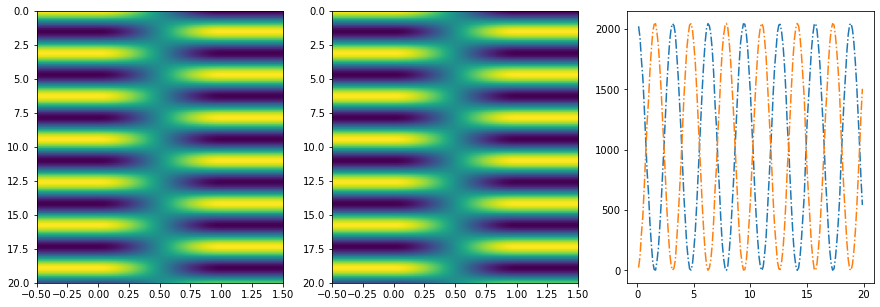

In [ ]:
X,Y,Z = getStruturedData_grid(data,n_qubits)
x,y,z = getStruturedData_seq(data,n_qubits = n_qubits )


f, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index[:20]],z[index[:20]], '-.')

plt.savefig('test.png')

The results could not be more clearer!


**Exercises**

1. Compute the channel/barrier capacity between the two wells. If you are unable to use this analogy, compute the reflection and transmission coefficients of the barrier between the well.


### Rabi oscillations

The other effect to investigate, is are the Rabi oscillations that occurs when a state transitions between two states.

So let us consider a single well with two possible states, but now we introduce some coupling between them.

In [15]:
# Initializing a two-qubit quantum state
n_levels =  2
n_wells = 1
t_max = 100.0
dt = 0.1
shots =2048

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1


H0 = [
    [0.5,0.5],
    [0.5,1.5]  
]

data = W_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots,noise_thermal = None)

number of wells: 1 number of levels: 2 number of qubits: 1
number of states in register: 2
[[0.5 0.5]
 [0.5 1.5]]


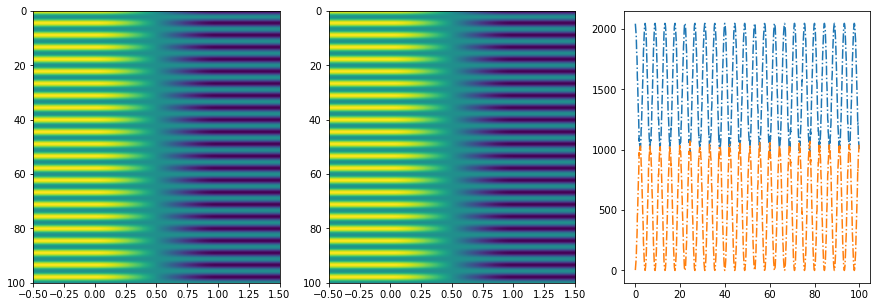

In [16]:
X,Y,Z = getStruturedData_grid(data,n_qubits)
x,y,z = getStruturedData_seq(data,n_qubits = n_qubits )


f, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index],z[index], '-.')

plt.savefig('test.png')

Let us now see what happens if we introduce some thermal noise.

In [17]:
# Initializing a two-qubit quantum state
n_levels =  2
n_wells = 1
t_max = 100.0
dt = 0.1
shots =2048

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1

g0 = 0.1
G0 = [
    [g0,g0],
    [g0,g0] 
]
H0 = [
    [0.5,0.5],
    [0.5,1.5]  
]

noise_thermal = generate_noise_model(n_qubits, T1 = 1.0e3, dT1 = 0.1e3)
print(noise_thermal)

data = KP_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots,noise_thermal = noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'reset', 'measure', 'u3', 'cx']
  Qubits with noise: [0]
  Specific qubit errors: [('reset', [0]), ('measure', [0]), ('u2', [0]), ('u3', [0]), ('cx', [0, 0])]
number of wells: 1 number of levels: 2 number of qubits: 1
number of states in register: 2
[[0.5 0.5]
 [0.5 1.5]]


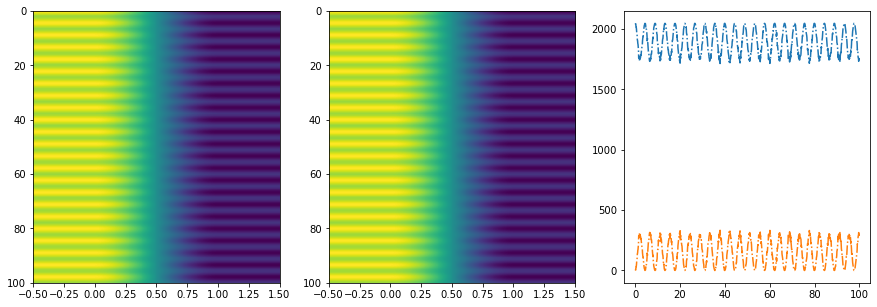

In [18]:
X,Y,Z = getStruturedData_grid(data,n_qubits)
x,y,z = getStruturedData_seq(data,n_qubits = n_qubits )


f, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index],z[index], '-.')

plt.savefig('test.png')



<div class="alert alert-block alert-info">
<b>Question 1:</b> Can you interpret what is going on? Basically the thermal fluctuations are killing the oscillations! Why?
</div>
    
  
Now, let put tunneling, Rabi oscillations, and thermal noise altogether.

In [19]:
# Initializing a two-qubit quantum state
n_levels =  4
n_wells = 2
t_max = 200.0
dt = 1.0
shots =2048

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1

g0 = 0.05
G0 = [
    [g0,g0,g0,g0],
    [g0,g0,g0,g0],
    [g0,g0,g0,g0],
    [g0,g0,g0,g0]  
]
H0 = [
    [0.5,0.1,0,0],
    [0.1,1.5,0.1,0],
    [0,0.1,2.5,0.1],
    [0,0,0.1,3.5]   
]

noise_thermal = generate_noise_model(n_qubits, T1 = 5.0e3, dT1 = 1.0e3)
print(noise_thermal)

data = KP_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots,noise_thermal = noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'reset', 'measure', 'u3', 'cx']
  Qubits with noise: [0, 1, 2]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2])]
number of wells: 2 number of levels: 4 number of qubits: 3
number of states in register: 8
[[0.5  0.1  0.   0.   0.05 0.05 0.05 0.05]
 [0.1  1.5  0.1  0.   0.05 0.05 0.05 0.05]
 [0.   0.1  2.5  0.1  0.05 0.05 0.05 0.05]
 [0.   0.   0.1  3.5  0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05 0.5  0.1  0.   0.  ]
 [0.05 0.05 0.05 0.05 0.1  1.5  0.1  0.  ]
 [0.05 0.05 0.05 0.05 0.   0.1  2.5  0.1 ]
 [0.05 0.05 0.05 0.05 0.   0.   0.1  3.5 ]]


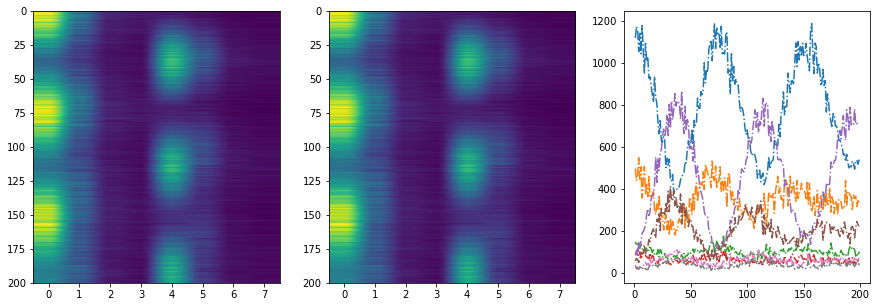

In [20]:
X,Y,Z = getStruturedData_grid(data,n_qubits)
x,y,z = getStruturedData_seq(data,n_qubits = n_qubits )


f, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index],z[index], '-.')

plt.savefig('test.png')

<div class="alert alert-block alert-info">
<b>Question 2:</b> Can you use the intuition gathered in the previous examples to provide a more complete interpretation of these results?
</div>


### The Kronig-Penney model

The Kronig-Penney model is a theoretical model used in solid-state physics to describe the behavior of electrons in a periodic potential. It consists of a series of potential wells separated by potential barriers, which are repeated in a periodic fashion. The model can be used to study the electronic band structure of a one-dimensional crystal, and provides a framework for understanding phenomena such as electronic conductivity and the formation of energy bands. In the Kronig-Penney model, the wave function of the electron is a periodic function that satisfies the Schrödinger equation, subject to periodic boundary conditions. The model can be used to calculate the electronic dispersion relation, which describes the relationship between the energy and momentum of an electron in the crystal. The Kronig-Penney model is a useful tool for studying the electronic properties of materials, and has been applied in a variety of contexts including semiconductor physics, quantum dots, and photonic crystals.

The model assumes that the electrons are free to move in the crystal lattice, and that their motion is influenced by periodic potential energy barriers.

The potential energy of the crystal lattice can be described by a periodic function:

\begin{equation}
V(x)=V_0\sum_{n=-\infty}^{\infty} \delta(x-na)
\end{equation}

where $V_0$ is the height of the potential energy barrier, $a$ is the lattice spacing, and $\delta$ is the Dirac delta function.

The Schrödinger equation for a single electron in the crystal lattice can be written as:

\begin{equation}
-\frac{\hbar^2}{2m}\frac{d^2\psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x)
\end{equation}

where $\psi(x)$ is the wave function of the electron, $m$ is its mass, $\hbar$ is the reduced Planck constant, and $E$ is its energy.

Using the periodicity of the potential energy function, the wave function can be written as a sum of plane waves:

\begin{equation}
\psi(x) = \sum_{n=-\infty}^{\infty} c_n e^{ik_nx}
\end{equation}

where $c_n$ are constants and $k_n$ is the wave vector of the $n$-th plane wave, given by $k_n = \frac{2\pi n}{a}$.

The coefficients $c_n$ can be determined by applying boundary conditions at the potential energy barriers. By matching the wave function and its derivative at the barriers, the allowed energy levels and corresponding wave functions can be obtained.

The Kronig-Penney model is a simplified model of a crystal lattice, but it provides a useful framework for understanding the behavior of electrons in more complex systems.

In [21]:
## Initializing the quantum state
n_levels =  1
n_wells = 32
t_max = 10.0
dt = 0.01
shots =2048

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1

g0 = 1.5
G0 = [[g0]]
H0 = [[10.0]]


data = KP_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots,noise_thermal = None)

number of wells: 32 number of levels: 1 number of qubits: 5
number of states in register: 32
[[10.   1.5  0.  ...  0.   0.   0. ]
 [ 1.5 10.   1.5 ...  0.   0.   0. ]
 [ 0.   1.5 10.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ... 10.   1.5  0. ]
 [ 0.   0.   0.  ...  1.5 10.   1.5]
 [ 0.   0.   0.  ...  0.   1.5 10. ]]


(999, 32)
(999, 32)


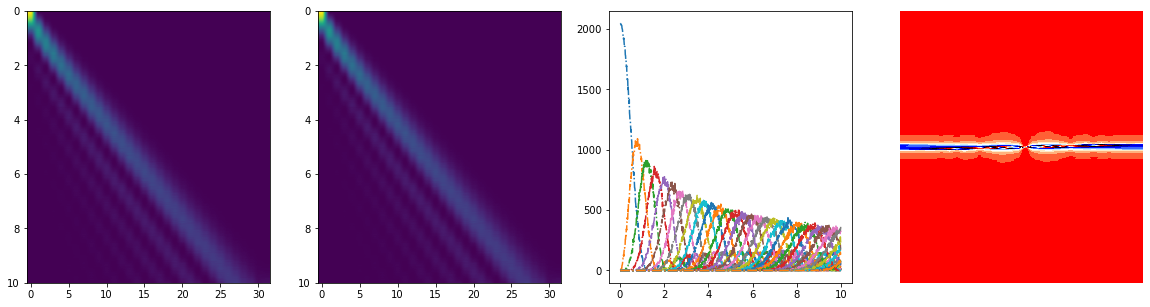

In [22]:
X,Y,Z = getStruturedData_grid(data,n_qubits)
x,y,z = getStruturedData_seq(data,n_qubits = n_qubits )
print(Z.shape)


f, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index],z[index], '-.')

iZ = np.fft.fft2(Z)
iZ = np.fft.fftshift(iZ)
#iZ = np.swapaxes(iZ,0,1)
print(Z.shape)
ax[3].axis('off')
ax[3].imshow(np.abs(iZ[:,:]), aspect='auto', interpolation = 'hanning',cmap = 'flag')
plt.savefig('test.png')

The Fourier transform of the probability density plot, also known as the momentum space plot, provides information about the distribution of momentum states of the wavefunction. This plot can help identify the properties of the dispersion relation of the wavefunction because the momentum of a particle is related to its energy through the dispersion relation.

The dispersion relation describes how the energy of a particle varies with its momentum in a given system. By analyzing the momentum space plot, we can identify the peaks and valleys that correspond to the allowed momentum states of the system. These peaks and valleys are related to the energy levels of the system through the dispersion relation.

For example, in the Kronig-Penney model, the periodicity of the crystal lattice potential energy function results in a series of allowed energy levels separated by energy gaps. The momentum space plot will show peaks at the momentum values corresponding to these allowed energy levels. By analyzing the position and shape of these peaks, we can infer information about the properties of the dispersion relation and the behavior of the wavefunction in the system.


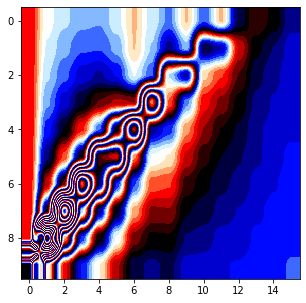

In [23]:
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(iZ[490:500,16:]), aspect='auto', interpolation = 'hanning',cmap = 'flag')

<div class="alert alert-block alert-warning">
<b>Code Explained: </b>    
    
    
This code implements the Kronig-Penney model by initializing a quantum state and then calculating the time evolution of the system using the Hamiltonian and coupling matrices.

In this code, the quantum state is initialized with a single particle occupying the first well. The Hamiltonian matrix (H0) and coupling matrix (G0) are defined based on the potential energy function. The time evolution of the quantum state is then calculated using the KP_model function, which takes the initial state, Hamiltonian, and coupling matrices as input, along with the time interval, time step, and number of shots.

The resulting data is then structured and visualized using matplotlib. The first two plots show the time evolution of the quantum state, with the second plot using hanning interpolation. The third plot shows the probability density of the particle at each well. The final plot shows the Fourier transform of the probability density.

Overall, this code demonstrates the implementation and visualization of the Kronig-Penney model in a quantum system.

The code is an implementation of the Kronig-Penney model, which describes the behavior of electrons in a one-dimensional crystal lattice. It initializes the quantum state by setting the number of energy levels, number of potential wells, simulation time, time step, and shots. It then calculates the Hamiltonian and applies it to the initial state to obtain the time evolution of the system. The resulting data is visualized using four plots, which display the time evolution of the quantum state, the same plot with a hanning interpolation, a plot of the wave function at each lattice site, and a Fourier transform of the time evolution data. The last plot shows the spectral density of the system, which indicates the allowed energy levels and corresponding wave functions. The code also saves the final plot as a PNG file.
</div>

Let us try the same code with other parameters:

In [24]:
## Initializing the quantum state
n_levels =  1
n_wells = 32
t_max = 10.0
dt = 0.01
shots =2048

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1

g0 = 1.5
G0 = [[g0]]
H0 = [[10.0]]

noise_thermal = generate_noise_model(n_qubits, T1 = 50e3, dT1 = 10e3)
print(noise_thermal)

data = KP_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots,noise_thermal = noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'reset', 'measure', 'u3', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [0, 4]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [1, 4]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [2, 4]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3]), ('cx', [3, 4]), ('cx', [4, 0]), ('cx', [4, 1]), ('cx', [4, 2]), ('cx', [4, 3]), ('cx', [4, 4])]
number of wells: 32 number of levels: 1 number of qubits: 5
number of states in register: 32
[[10.   1.5  0.  ...  0.  

C:\Users\Ariel Guerreiro\.conda\envs\QInformation\lib\site-packages\qiskit\extensions\quantum_initializer\squ.py:129: RuntimeWarning: invalid value encountered in arccos
  beta = 2 * np.arccos(np.abs(u00))


(999, 32)
(999, 32)


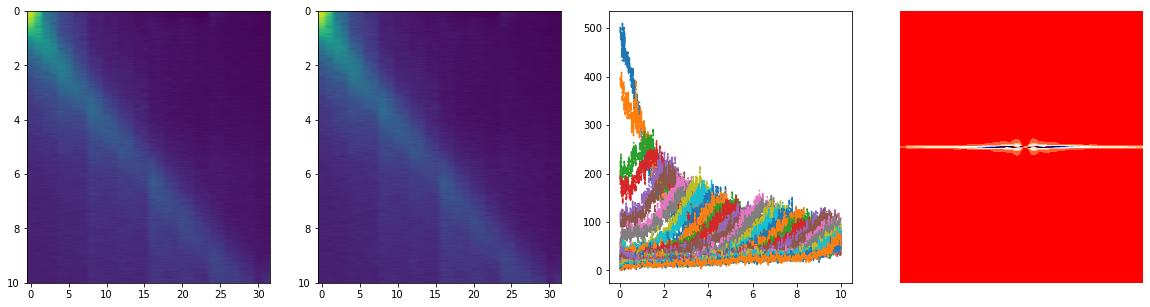

In [25]:
X,Y,Z = getStruturedData_grid(data,n_qubits)
x,y,z = getStruturedData_seq(data,n_qubits = n_qubits )
print(Z.shape)


f, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index],z[index], '-.')

iZ = np.fft.fft2(Z)
iZ = np.fft.fftshift(iZ)
#iZ = np.swapaxes(iZ,0,1)
print(Z.shape)
ax[3].axis('off')
ax[3].imshow(np.abs(iZ[:,:]), aspect='auto', interpolation = 'hanning',cmap = 'flag')
plt.savefig('test.png')

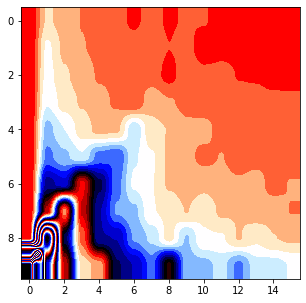

In [26]:
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(iZ[490:500,16:]), aspect='auto', interpolation = 'hanning',cmap = 'flag')

In [27]:
## Initializing the quantum state
n_levels =  1
n_wells = 128 *2
t_max = 100.0
dt = 0.125
shots =2048

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1

g0 = 1.
G0 = [[g0]]
H0 = [[10.0]]


data = KP_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots,noise_thermal = None)

number of wells: 256 number of levels: 1 number of qubits: 8
number of states in register: 256
[[10.  1.  0. ...  0.  0.  0.]
 [ 1. 10.  1. ...  0.  0.  0.]
 [ 0.  1. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 10.  1.  0.]
 [ 0.  0.  0. ...  1. 10.  1.]
 [ 0.  0.  0. ...  0.  1. 10.]]


(799, 256)
(799, 256)


<ipython-input-37-c5bc416b6bfd>:18: RuntimeWarning: divide by zero encountered in log
  ax[3].imshow(np.log(np.abs(iZ[:,:])), aspect='auto', interpolation = 'hanning')


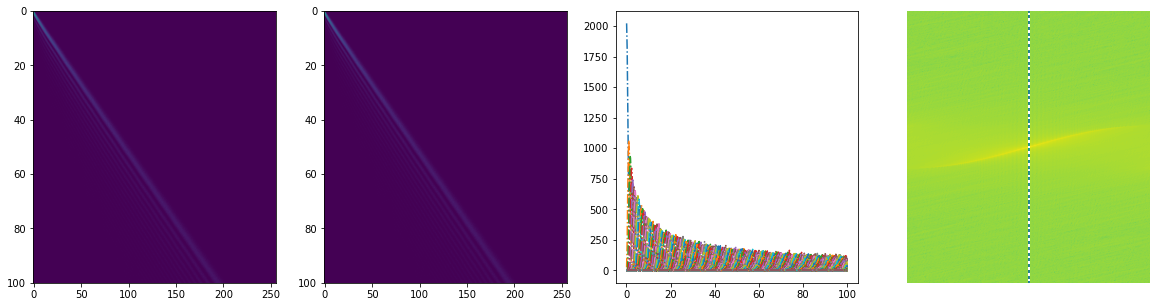

In [37]:
X,Y,Z = getStruturedData_grid(data,n_qubits)
x,y,z = getStruturedData_seq(data,n_qubits = n_qubits )
print(Z.shape)


f, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index],z[index], '-.')

iZ = np.fft.fft2(Z)
iZ = np.fft.fftshift(iZ)
#iZ = np.swapaxes(iZ,0,1)
print(Z.shape)
ax[3].axis('off')
ax[3].imshow(np.log(np.abs(iZ[:,:])), aspect='auto', interpolation = 'hanning')
plt.savefig('test.png')

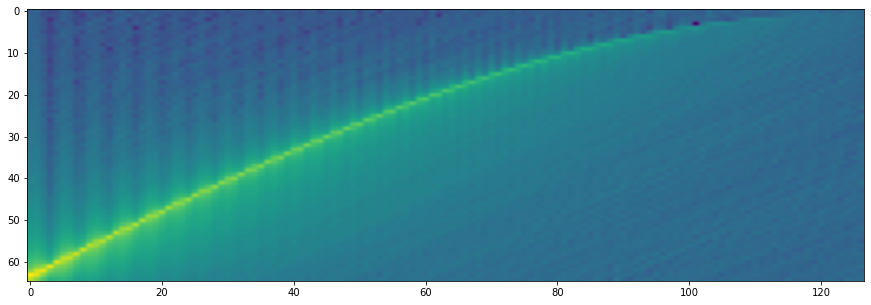

In [33]:
plt.figure(figsize=(15, 5))
plt.imshow(np.log(np.abs(10*iZ[335:400,129:])), aspect='auto', interpolation = 'hanning')

Let us try almost the same code with other parameters:

In [43]:
## Initializing the quantum state
n_levels =  2
n_wells = 32
t_max = 100.0
dt = 0.125
shots =2048

n_qubits, n_states = getNumberQubits(n_levels,n_wells)
initial_state = [0] * n_states
initial_state[0] = 1


g0 = 1.
G0 = [
    [g0,0],
    [0,0] 
]
H0 = [
    [0.5,0.5],
    [0.5,10.5]  
]


data = KP_model(initial_state,n_levels,n_wells, H0, G0, t_max, dt, shots,noise_thermal = None)

number of wells: 32 number of levels: 2 number of qubits: 6
number of states in register: 64
[[ 0.5  0.5  1.  ...  0.   0.   0. ]
 [ 0.5 10.5  0.  ...  0.   0.   0. ]
 [ 1.   0.   0.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ... 10.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5  0.5]
 [ 0.   0.   0.  ...  0.   0.5 10.5]]


(799, 64)
(799, 64)


<ipython-input-44-c5bc416b6bfd>:18: RuntimeWarning: divide by zero encountered in log
  ax[3].imshow(np.log(np.abs(iZ[:,:])), aspect='auto', interpolation = 'hanning')


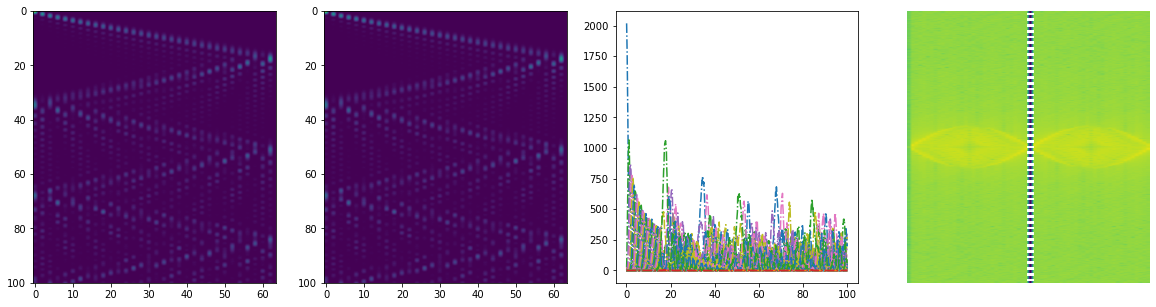

In [44]:
X,Y,Z = getStruturedData_grid(data,n_qubits)
x,y,z = getStruturedData_seq(data,n_qubits = n_qubits )
print(Z.shape)


f, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0))
ax[1].imshow(Z, aspect='auto', extent=(-0.5, n_states-0.5, t_max, 0), interpolation = 'hanning')
for i in range(n_states):
    index = np.where(y==i)
    ax[2].plot(x[index],z[index], '-.')

iZ = np.fft.fft2(Z)
iZ = np.fft.fftshift(iZ)
#iZ = np.swapaxes(iZ,0,1)
print(Z.shape)
ax[3].axis('off')
ax[3].imshow(np.log(np.abs(iZ[:,:])), aspect='auto', interpolation = 'hanning')
plt.savefig('test.png')

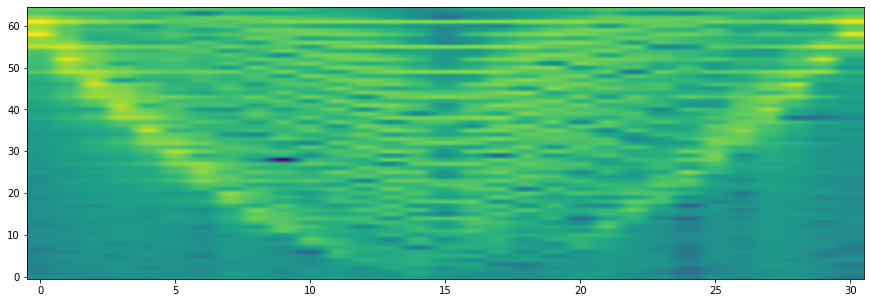

In [45]:
plt.figure(figsize=(15, 5))
plt.imshow(np.log(np.abs(10*iZ[335:400,33:])), aspect='auto', interpolation = 'hanning',origin='lower')

<div class="alert alert-block alert-info">
<b>Question 3:</b> Provide an interpretation of the previous plots? Can you identify the relevant physical phenomena predicted for the Kronig-Penney model?
</div>